In [139]:
# Download Libraries 
%pip install rasterio
%pip install scikit-image
%pip install -U efficientnet_pytorch
%pip install pytorch-metric-learning
%pip install -q timm
%pip install tqdm
%pip install ipywidgets 
%pip install torchvision
%pip install albumentations
%pip install pyproj


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgr

In [2]:
%pip install "torch>=2.0.0"
%pip install "shapely>=2.0.0"


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import albumentations as A

import torch
from torch.optim import lr_scheduler
import copy

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.cuda import amp
from time import time

from PIL import Image, ImageDraw

import glob
import pickle

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

In [141]:
# Check file or directory is exist
BASE_DIR = "CAM-ForestNetDataset"
SUB_DIR = "Landsat-Grouped"

train_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/val.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Oil palm plantation,Plantation,4.540875,9.538000,2015,examples/9.538_4.540875
1,Other large-scale plantations,Plantation,4.190500,9.336000,2015,examples/9.336000000000002_4.190500000000001
2,Other large-scale plantations,Plantation,4.603583,12.232104,2015,examples/12.232104166666666_4.603583333333333
3,Fruit plantation,Plantation,4.729375,9.667375,2015,examples/9.667375_4.729374999999999
4,Rubber plantation,Plantation,4.389250,9.574125,2015,examples/9.574125_4.38925


(1, 332, 332)


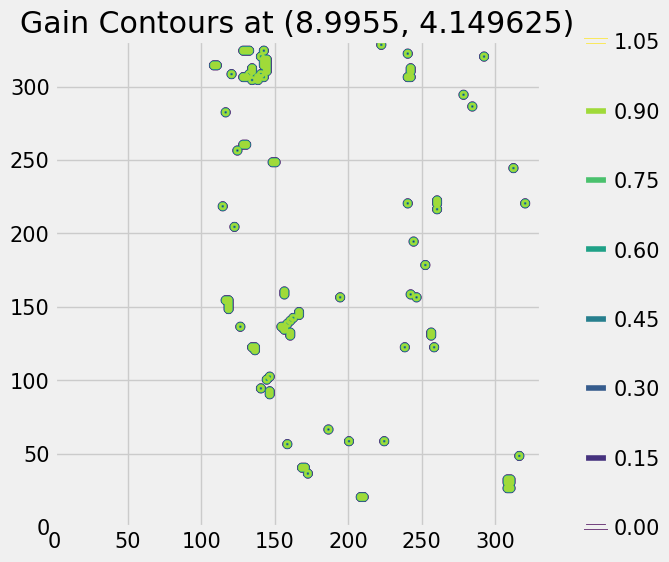

In [142]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

(332, 332)


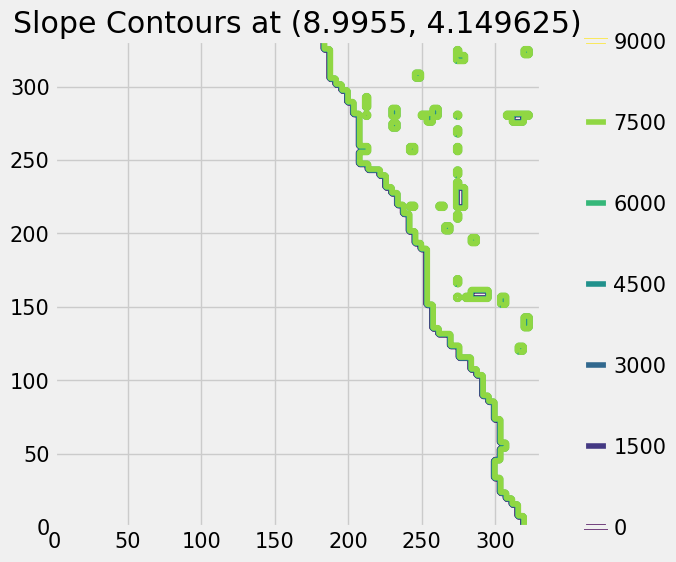

In [143]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/slope.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            )
plt.title("Slope Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

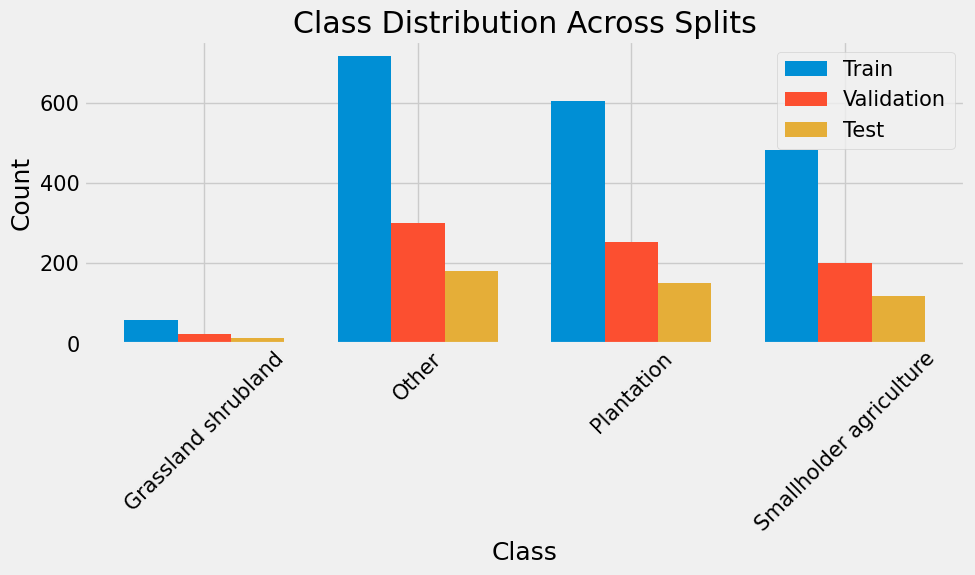

In [145]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train, val, test):
    # Get all unique categories from all datasets
    all_categories = list(set(train['merged_label']) | 
                     set(val['merged_label']) | 
                     set(test['merged_label']))
    all_categories.sort()  # Sort alphabetically
    
    # Create positions for bars
    x = np.arange(len(all_categories))
    width = 0.25
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Function to get counts for each split
    def get_counts(df):
        counts = df['merged_label'].value_counts()
        return [counts.get(cat, 0) for cat in all_categories]
    
    # Plot bars for each split
    plt.bar(x - width, get_counts(train), width, label='Train')
    plt.bar(x, get_counts(val), width, label='Validation')
    plt.bar(x + width, get_counts(test), width, label='Test')
    
    # Add labels and formatting
    plt.xticks(x, all_categories, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Splits')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your actual data:
plot_class_distribution(train_df, val_df, test_df)

In [ ]:
from pyproj import Transformer
from rasterio.transform import from_origin

def load_first_png_image(folder_path):
        png_files = glob.glob(os.path.join(folder_path, '*.png'))

        if not png_files:
            raise FileNotFoundError(f"No PNG files found in {folder_path}")
 
        image = io.imread(png_files[0])
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir='CAM-ForestNetDataset', sub_dir="Landsat-Grouped", transform=None, detailed_labels=False, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.sub_dir = sub_dir
        self.transform = transform
        if detailed_labels:
            self.label_to_int = {'Oil palm plantation': 0, 'Timber plantation': 1, 'Fruit plantation (e.g. banana)': 2, 'Rubber plantation': 3, 'Other large-scale plantation (e.g. tea, sugarcane)': 4, 'Grassland/Shrubland': 5, 'Small-scale oil palm plantation': 6, 'Small-scale maize plantation': 7, 'Other small-scale agriculture': 8, 'Mining': 9, 'Selective logging': 10, 'Infrastructure': 11, 'Wildfire': 12, 'Hunting': 13, 'Other': 14}
        else:
            self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        
        self.types = types

    def __len__(self):
        return len(self.csv)
    
    def poly_from_utm(self, polygon):
        poly_pts = []
        print(polygon.bounds)

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        
        ## Load the image and auxiliary
        image = load_first_png_image(f'{self.root_dir}/{self.sub_dir}/{folder}/images/visible')
        slope = np.load(f'{self.root_dir}/{self.sub_dir}/{folder}/auxiliary/slope.npy')
          
        ## Get the segmentation map
        with open(f'{self.root_dir}/{self.sub_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)
      
        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)
              
        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        # Convert (lat, lon) to UTM using pyproj
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)  # You may need to dynamically set EPSG
        utm_x, utm_y = transformer.transform(long, lat)

        # Compute top-left corner (image is centered at utm_x, utm_y)
        pixel_size = 15  # Landsat resolution in meters
        half_size = (332 // 2) * pixel_size
        x_min = utm_x - half_size
        y_max = utm_y + half_size

        transform = from_origin(x_min, y_max, pixel_size, pixel_size)

        mask = rasterize(
            shapes=[(poly, 1) for poly in poly_shp],
            out_shape=(nx, ny),
            transform=transform,
            fill=0,
            dtype=np.uint8
        )

        seg = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
          
        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image, seg, merged_label
 

In [166]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [167]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [169]:

train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR)
val_dataset = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
test_dataset = ForestDataset( csv_file_to_df=test_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

images shape on PyTorch :  torch.Size([16, 3, 160, 160])
seg shape on PyTorch :  torch.Size([16, 160, 160])
slope shape on PyTorch :  torch.Size([16, 160, 160])
labels shape on Pytorch :  torch.Size([16])


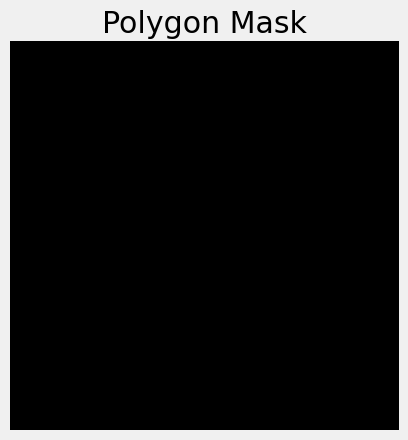

In [173]:
dataiter = iter(trainloader)
images, seg, slope, labels = next(dataiter)

print('images shape on PyTorch : ', images.size())
print('seg shape on PyTorch : ', seg.size())
print('slope shape on PyTorch : ', slope.size())
print('labels shape on Pytorch : ', labels.size())

plt.imshow(seg[10].numpy(), cmap='gray')
plt.title("Polygon Mask")
plt.axis('off')
plt.show()

In [134]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [114]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [115]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

## Multimodal SuperCon using UNet

In [16]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler('cpu')

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train','val']:
            if(phase == 'train'):
                model.train() 
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,seg,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                seg=seg.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [17]:
"""Training Projection Head"""

unet_down_model = UNet(3,1,"projection")
unet_down_model = unet_down_model.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(unet_down_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(unet_down_model, criterion, optimizer, scheduler, 20, dataloaders_re)

Epoch 1/20
----------
train Loss: 0.5770
val Loss: 0.1968
Epoch 2/20
----------
train Loss: 0.5790
val Loss: 0.1968
Epoch 3/20
----------
train Loss: 0.5814
val Loss: 0.1968
Epoch 4/20
----------
train Loss: 0.5793
val Loss: 0.1952
Epoch 5/20
----------
train Loss: 0.5763
val Loss: 0.1958
Epoch 6/20
----------
train Loss: 0.5766
val Loss: 0.1960
Epoch 7/20
----------
train Loss: 0.5757
val Loss: 0.1956
Epoch 8/20
----------
train Loss: 0.5733
val Loss: 0.1955
Epoch 9/20
----------
train Loss: 0.5718
val Loss: 0.1959
Epoch 10/20
----------
train Loss: 0.5752
val Loss: 0.1962
Epoch 11/20
----------
train Loss: 0.5756
val Loss: 0.1954
Epoch 12/20
----------
train Loss: 0.5720
val Loss: 0.1959
Epoch 13/20
----------
train Loss: 0.5733
val Loss: 0.1957
Epoch 14/20
----------
train Loss: 0.5759
val Loss: 0.1959
Epoch 15/20
----------
train Loss: 0.5684
val Loss: 0.1960
Epoch 16/20
----------
train Loss: 0.5765
val Loss: 0.1955
Epoch 17/20
----------
train Loss: 0.5740
val Loss: 0.1957
Epoch 

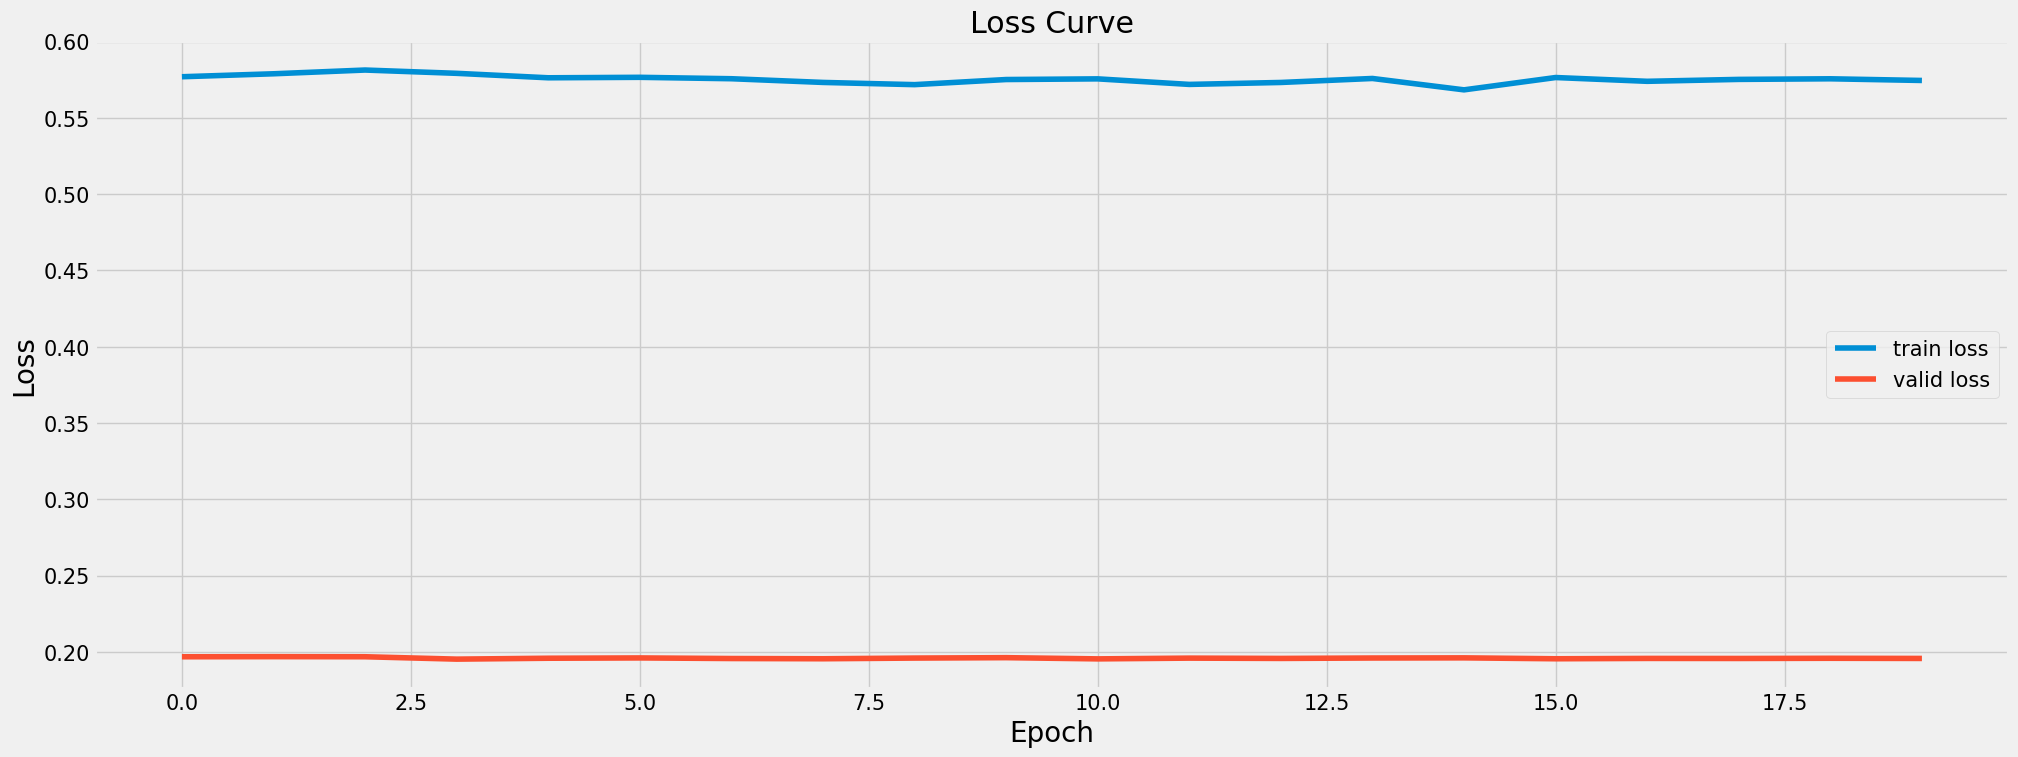

In [18]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22,8))
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

In [19]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [20]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,1,"classification")
unet_model = unet_model.to(device)

optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [21]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  

            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                images = images.to(device)
                seg = seg.to(device)
                slope = slope.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
                running_acc_seg += m_avg
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()
                
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc Seg: {:.4f} Acc Class: {:.4f}'.format(
                phase, epoch_loss, epoch_acc_seg, epoch_acc_class))
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc_class > best_acc:
                best_acc = epoch_acc_class
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [22]:
unet_classifier_segmentation = train_model(unet_model, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.4940 Acc Seg: 0.4996 Acc Class: 0.4193
val Loss: 1.5556 Acc Seg: 0.5000 Acc Class: 0.4054
Epoch 2/15
----------
train Loss: 1.3163 Acc Seg: 0.5000 Acc Class: 0.5604
val Loss: 1.3727 Acc Seg: 0.5000 Acc Class: 0.4707
Epoch 3/15
----------
train Loss: 1.2038 Acc Seg: 0.5000 Acc Class: 0.6774
val Loss: 1.4959 Acc Seg: 0.5000 Acc Class: 0.4398
Epoch 4/15
----------
train Loss: 1.0169 Acc Seg: 0.5000 Acc Class: 0.7596
val Loss: 0.6597 Acc Seg: 0.5000 Acc Class: 0.4298
Epoch 5/15
----------
train Loss: 0.5382 Acc Seg: 0.5000 Acc Class: 0.7922
val Loss: 0.9708 Acc Seg: 0.5000 Acc Class: 0.4258
Epoch 6/15
----------
train Loss: 0.2941 Acc Seg: 0.5000 Acc Class: 0.7532
val Loss: 1.1410 Acc Seg: 0.5000 Acc Class: 0.4186
Epoch 7/15
----------
train Loss: 0.1657 Acc Seg: 0.5000 Acc Class: 0.7965
val Loss: 0.9088 Acc Seg: 0.5000 Acc Class: 0.4074
Epoch 8/15
----------
train Loss: 0.1127 Acc Seg: 0.5000 Acc Class: 0.8339
val Loss: 1.2172 Acc Seg: 0.5000 Acc Class:

In [23]:
print(acc_class_dict)
print(acc_seg_dict)
print(loss_dict)

{'train': [0.41933760683760685, 0.5603632478632479, 0.6773504273504274, 0.7596153846153846, 0.7922008547008547, 0.7532051282051282, 0.7964743589743589, 0.8338675213675214, 0.8301282051282052, 0.8616452991452992, 0.8691239316239316, 0.8723290598290598, 0.8920940170940171, 0.8867521367521367, 0.9001068376068376], 'val': [0.40535714310042714, 0.47066326530612246, 0.4397959186106312, 0.4298469387755102, 0.42576530636573323, 0.41862244873630755, 0.4073979593053156, 0.4017857142857143, 0.41275510252738484, 0.4125000001216421, 0.42091836734693877, 0.42755102046898436, 0.4341836735910299, 0.43494897959183676, 0.4104591839167537]}
{'train': [0.4996376172599629, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'val': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}
{'train': [1.4939953801978347, 1.3163203520652575, 1.2037728026381924, 1.016907430612124, 0.5382192723262005, 0.29405964522534966, 0.16572167453730208, 0.11268996434588717, 0.105090187

In [24]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

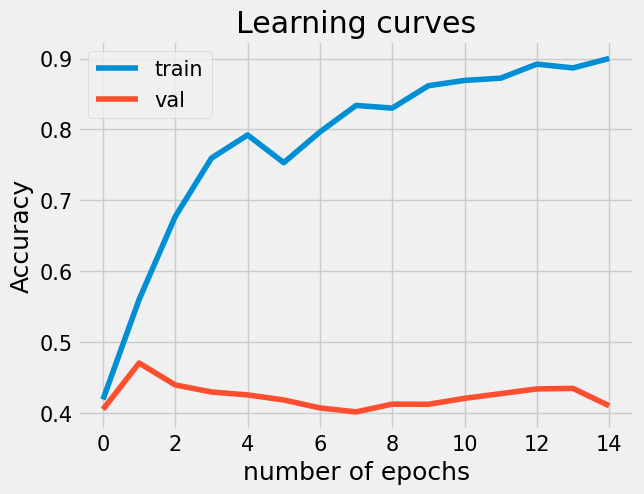

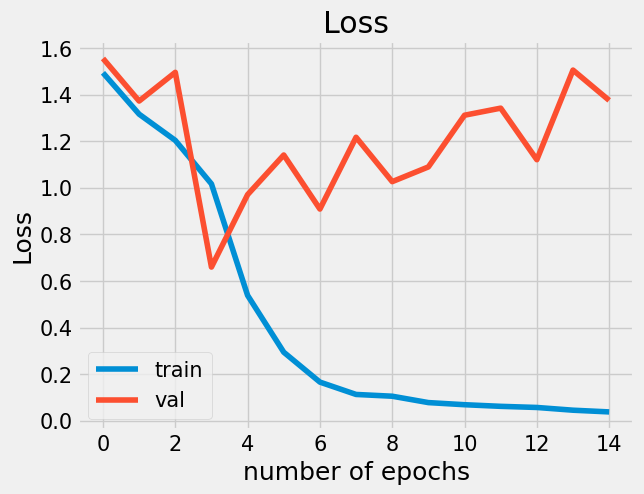

In [25]:
show_curves(acc_class_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

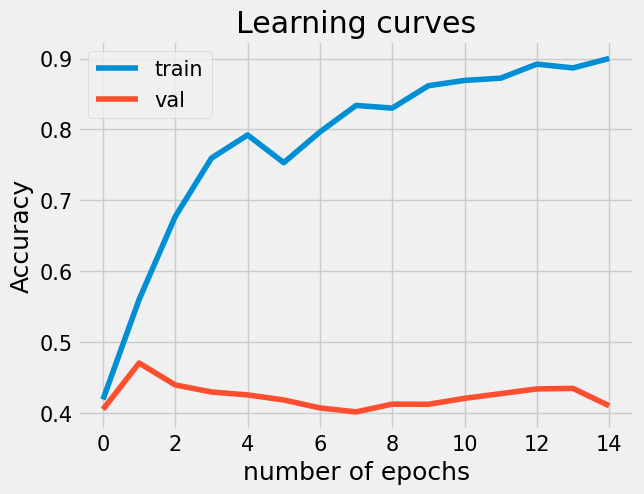

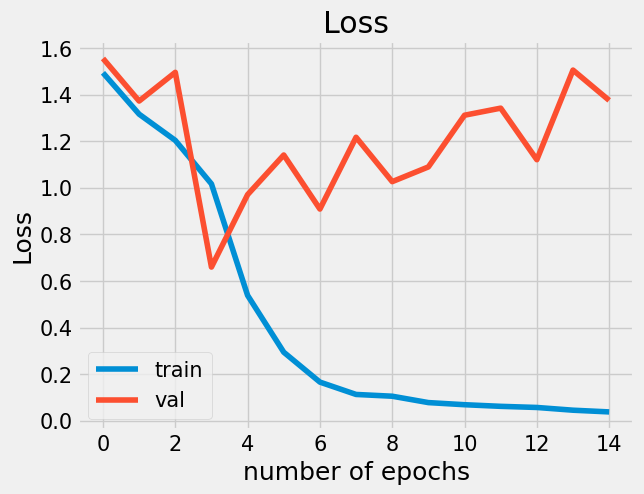

In [26]:
show_curves(acc_class_dict, loss_dict)

In [135]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in testloader: 
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)
            print("Raw output range:", outputs.min().item(), outputs.max().item())
            preds = torch.sigmoid(outputs)
            print("Sigmoid output range:", preds.min().item(), preds.max().item())  # Should be (0,1)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()

            
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader)))  

In [136]:
test(unet_classifier_segmentation)

Raw output range: -4.922085285186768 -2.834263324737549
Sigmoid output range: 0.007231253664940596 0.055500492453575134
Raw output range: -4.885919094085693 -1.8701730966567993
Sigmoid output range: 0.00749557139351964 0.1335216909646988
Raw output range: -4.920549392700195 -2.9535131454467773
Sigmoid output range: 0.007242288906127214 0.049570731818675995
Raw output range: -4.903648376464844 -2.2673590183258057
Sigmoid output range: 0.007364822085946798 0.09386259317398071
Raw output range: -4.887836456298828 -2.9552242755889893
Sigmoid output range: 0.0074813212268054485 0.049490176141262054
Raw output range: -4.904373645782471 -2.1459951400756836
Sigmoid output range: 0.007359521463513374 0.1047060564160347
Raw output range: -4.778989315032959 -1.5361294746398926
Sigmoid output range: 0.008334442041814327 0.17709864675998688
Raw output range: -4.900764465332031 -1.5458317995071411
Sigmoid output range: 0.007385934237390757 0.17568910121917725
Raw output range: -4.545839309692383 -3.

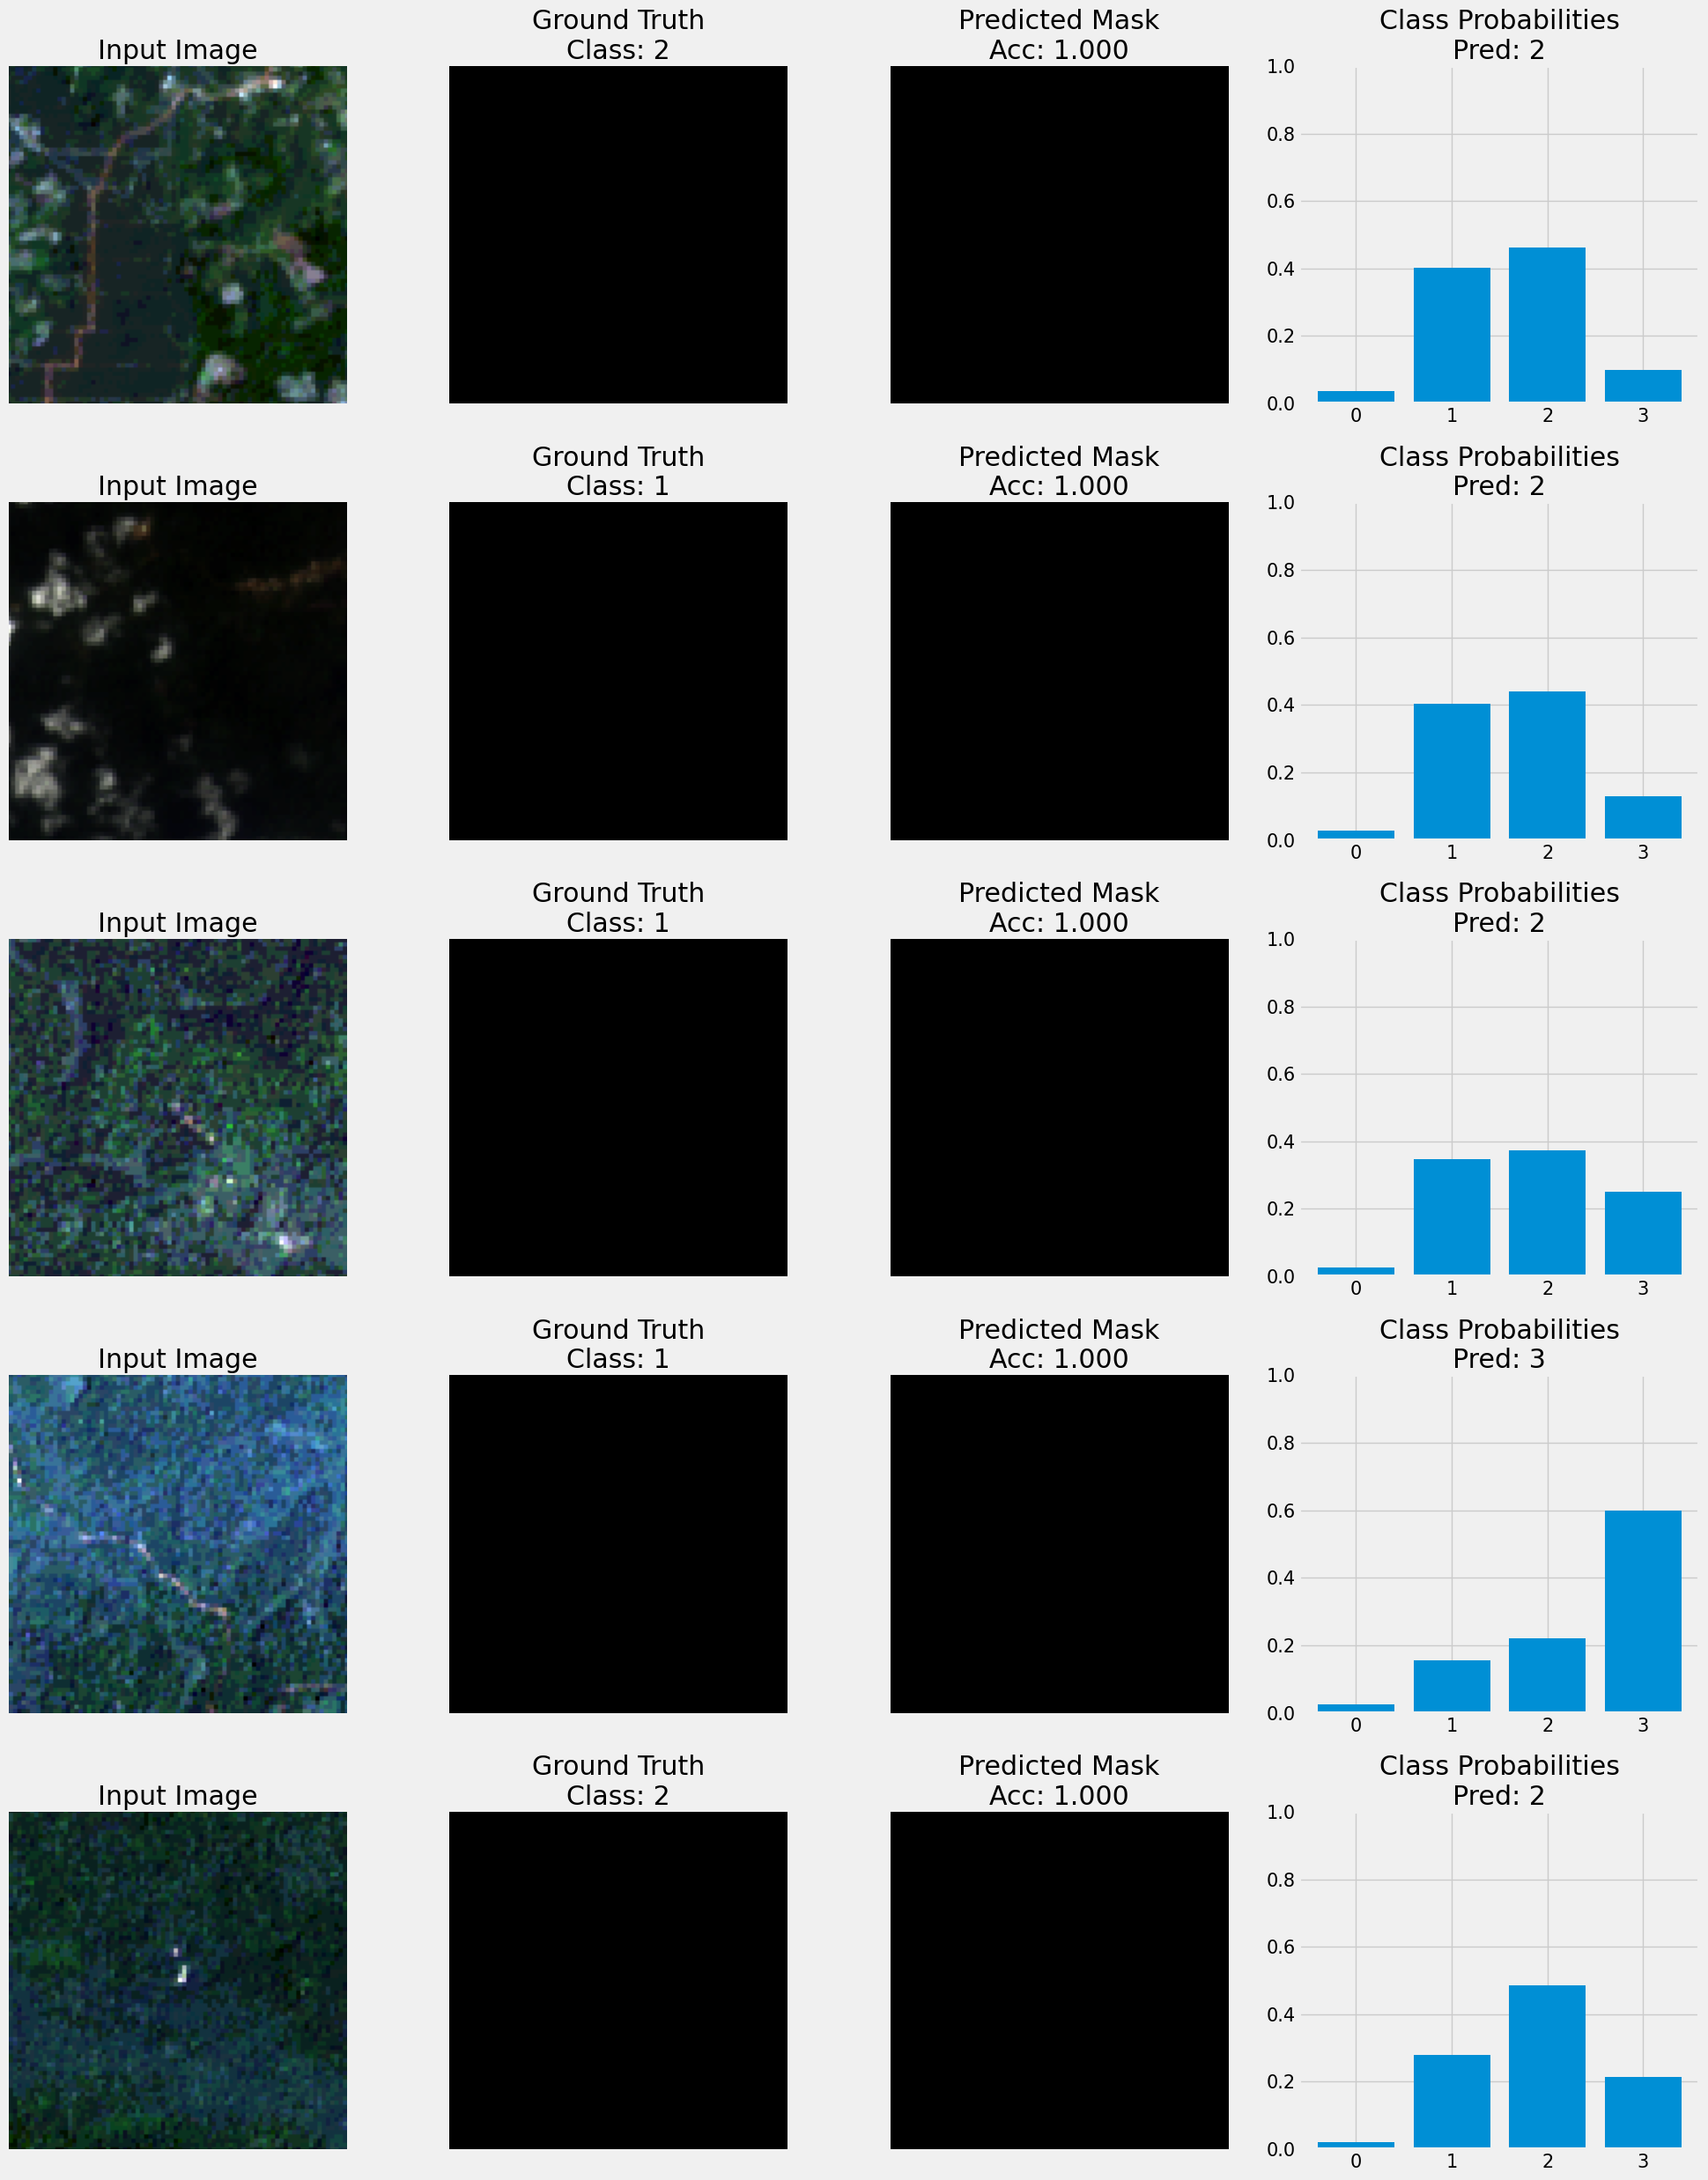

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_prediction_comparison(model, dataloader, num_examples=3):
    """Plot original vs predicted segmentation masks"""
    model.eval()
    fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_examples:
                break
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            
            outputs, out_class = model(images, slope)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            pred_class = torch.argmax(out_class, dim=1)
            
            img_np = images[0].cpu().permute(1,2,0).numpy()
            img_np = img_np.astype(np.float32)
            for c in range(3):
                channel = img_np[:, :, c]
                img_np[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-5)

            true_mask = seg[0].cpu().numpy()
            pred_mask = pred_masks[0, 0].cpu().numpy()
            
            accuracy = (pred_mask == true_mask).mean()
            
            axes[i,0].imshow(img_np)
            axes[i,0].set_title('Input Image')
            axes[i,0].axis('off')
            
            axes[i,1].imshow(true_mask, cmap='gray')
            axes[i,1].set_title(f'Ground Truth\nClass: {labels[0].item()}')
            axes[i,1].axis('off')
            
            axes[i,2].imshow(pred_mask, cmap='gray')
            axes[i,2].set_title(f'Predicted Mask\nAcc: {accuracy:.3f}')
            axes[i,2].axis('off')
            
            class_probs = torch.softmax(out_class[0], dim=0).cpu().numpy()
            num_classes = class_probs.shape[0]
            axes[i,3].bar([str(i) for i in range(num_classes)], class_probs)
            pred_class = torch.argmax(out_class[0]).item()
            axes[i,3].set_title(f'Class Probabilities\nPred: {pred_class}')
            axes[i,3].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_prediction_comparison(unet_classifier_segmentation, testloader, num_examples=5)